In [1]:
import string
import re
from itertools import combinations
import os
import requests
from multiprocess import Process, Manager
import numpy as np
from scipy.spatial import distance
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.downloader
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
articles = pd.read_csv(
    './data/rwe_news_prep.csv', 
    delimiter=';'
)
articles = articles.sample(
    frac=1
).reset_index(drop=True)#.head(1000)

articles = articles.dropna(
    subset=['time_stamp', 'title']
)

# clip news on weekend to friday
articles['time_stamp'] = pd.to_datetime(articles['time_stamp'])
articles['time_stamp'] -= pd.to_timedelta((articles['time_stamp'].dt.dayofweek - 4).clip(lower=0), unit='D')

In [3]:
punctuation = string.punctuation
punctuation += '•€'

stop_words = stopwords.words('english')
stop_words.extend(['rwe', 'aktiengesellschaft', 'rweoy', 'adr'])

lemmatizer = WordNetLemmatizer()

def map_postag(word):
    if word == 'NOUN':
        return 'n'
    elif word == 'VERB':
        return 'v'
    elif word == 'ADJ':
        return 'a'
    elif word == 'ADV':
        return 'r'
    else:
        return 'n'

def preprocessor(X):
    X = X.replace("\n", " ")
    X = X.replace("\t", " ")
    X = re.sub(r'[^A-Za-z0-9 ]+', '', X)
    # to lower
    X = X.lower()
    # punctuation
    X = X.translate(str.maketrans('', '', punctuation))
    # remove multi white space
    X = ' '.join(X.split())
    
    
    return X

def tokenizer(X):
    # tokenize
    X = word_tokenize(X, language='english')
    # pos tag
    X = pos_tag(X, tagset='universal')
    X = [(s[0], map_postag(s[1])) for s in X]
    # remove strange words
    q = [r'(.)\1\1', r'\d', 'www', 'http']
    X = [s for s in X if not any([bool(re.search(x, s[0])) for x in q])]
    X = [s for s in X if len(s[0]) < 20]
    # stopwords
    X = [s for s in X if len(s[0]) > 2]
    X = [s for s in X if not s[0] in stop_words]
    # lemmatize
    X = [lemmatizer.lemmatize(s[0], pos=s[1]) for s in X]
    
    return X

def pairwise_word_embedding_distance(topics, word_embedding_model, topk=10):
    """
    :param topk: how many most likely words to consider in the evaluation
    :return: topic coherence computed on the word embeddings similarities
    """
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than topk')
    else:
        count = 0
        sum_dist = 0
        for list1, list2 in combinations(topics, 2):
            count = count+1
            word_counts = 0
            dist = 0
            for word1 in list1[:topk]:
                for word2 in list2[:topk]:
                    try:
                        dist = dist + distance.cosine(word_embedding_model[word1], word_embedding_model[word2])
                        word_counts = word_counts + 1
                    except:
                        pass

            dist = dist/word_counts
            sum_dist = sum_dist + dist
        return sum_dist/count

# Data Understanding

time_stamp  \
0    2014-08-22   
1    2009-09-03   
2    2011-04-11   
3    2008-09-11   
4    2009-01-15   
...         ...   
3075 2012-05-14   
3076 2022-10-27   
3077 2017-12-01   
3078 2013-06-18   
3079 2012-09-12   

                                                                     title  
0     Germany to greenlight RWE deal to sell Dea unit to Russians - report  
1                      Price for RWE takeover of Essent trimmed by EUR950m  
2           RWE Gas Slovensko launches gas supplies to households - report  
3                       RWE says nuclear concession would boost renewables  
4              Fitch keeps RWE 's ratings despite Dutch Essent acquisition  
...                                                                    ...  
3075           RWE continues to review goals in regard to Nabucco Pipeline  
3076                   RWE ( RWE : EUR38.90) offers earnings yield of 5.2%  
3077                RWE AG ST Financial Reports: Financial statements 2012  
3078                       RWE submits plans for 1.2-GW offshore wind park  
3079              German RWE in talks to sell its 17% Nabucco stake to OMV  

[3080 rows x 2 columns]

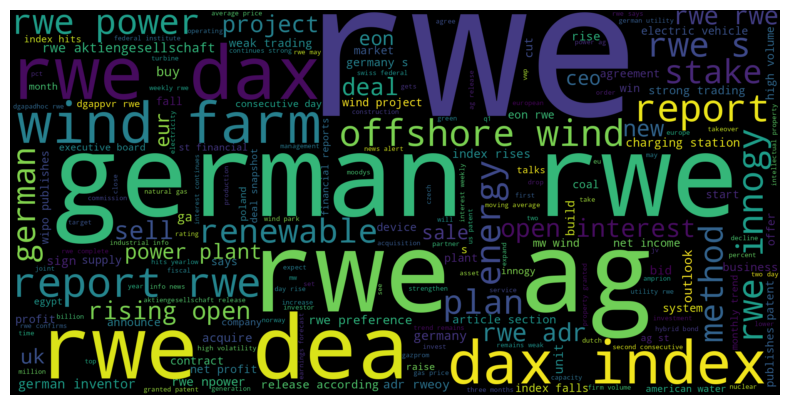

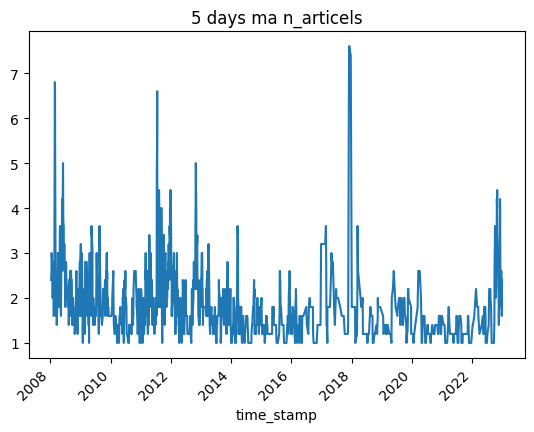

In [4]:
display(articles)

articles_string = articles['title'].to_list()
articles_string = ' '.join(articles_string)
articles_string = articles_string.lower()
articles_string = articles_string.translate(str.maketrans('', '', punctuation))
articles_string = ' '.join(articles_string.split())

wordcloud = WordCloud(width=2000, height=1000)
wordcloud.generate(articles_string)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

articles.groupby('time_stamp').size().rolling(5).mean().plot(kind='line',title='5 days ma n_articels')
plt.xticks(rotation = 45)
plt.show()

# Topic Modeling

In [5]:
def create_topic_activity(doc_topic: pd.DataFrame, docs: pd.DataFrame) -> pd.DataFrame:
    # insert time_stamp
    doc_topic['time_stamp'] = pd.to_datetime(docs['time_stamp'])

    # sum up news by date and company
    doc_topic['time_stamp'] = doc_topic['time_stamp'].dt.date
    count = doc_topic.groupby('time_stamp').size() + 0.0001
    topic_activity = doc_topic.groupby(['time_stamp']).sum()
    #topic_activity = topic_activity.div(count, axis=0)
    topic_activity['count'] = count

    # insert 0 for days with no news
    topic_activity.index = pd.to_datetime(topic_activity.index)
    topic_activity = topic_activity.asfreq('D', fill_value=0)

    # drop weekends
    topic_activity = topic_activity[topic_activity.index.get_level_values('time_stamp').dayofweek < 5]

    # add random validation topic
    topic_activity['topic_val_1'] = np.random.uniform(
        topic_activity.min().min(), topic_activity.max().max(),
        size=len(topic_activity)
    )
    
    topic_activity['topic_val_2'] = np.random.normal(
        scale=0.02,
        size=len(topic_activity)
    ) * topic_activity.max().max()
    
    topic_activity['topic_val_2'] = abs(topic_activity['topic_val_2']).astype('int')
    

    # compute moving average
    #topic_activity = topic_activity.ewm(halflife=5).mean()
    
    topic_activity.plot(
        kind='line',
        title='Topic Activity',
        subplots=True,
        figsize=(15, 10)
    )
    plt.tight_layout()
    plt.show()
    
    return topic_activity

## LDA

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


### Data preparation

In [7]:
%%time
lda_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    max_df=0.1,
    min_df=2,
    #ngram_range=(1,2)
)

X = lda_vectorizer.fit_transform(articles['title'])
lda_tokens = articles['title'].apply(lda_vectorizer.build_analyzer()).to_list()

print(f'n_articels: {X.shape[0]}')
print(f'n_features (words/ngrams): {X.shape[1]}')

n_articels: 3080
n_features (words/ngrams): 1676
CPU times: user 5.66 s, sys: 256 ms, total: 5.92 s
Wall time: 5.94 s


### Evaluation

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resour

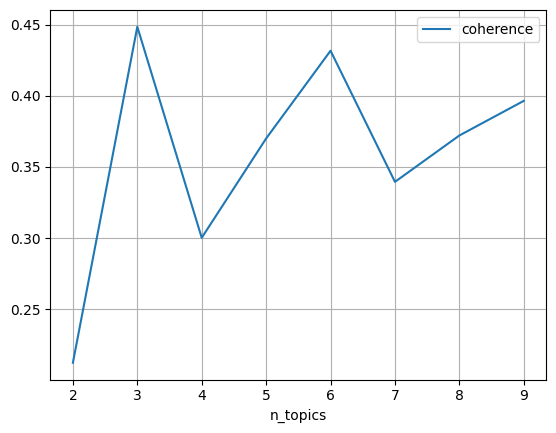

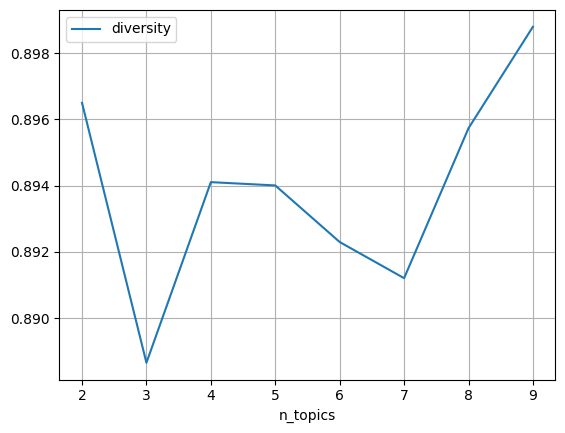

CPU times: user 37.9 s, sys: 2.43 s, total: 40.3 s
Wall time: 55.3 s


In [8]:
%%time
def compute_metrics(topic_coherence, t):
    # train lda
    lda = LatentDirichletAllocation(
        n_components=t,
        doc_topic_prior=None,
        topic_word_prior=None,
        learning_method='online',
        random_state=42,
    )
    lda.fit(X)

    # compute top words in topic
    topic_word = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    topic_word = pd.DataFrame(
        topic_word,
        index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
        columns=lda_vectorizer.get_feature_names_out()
    )
    topic_words = list()
    for topic in topic_word.index:
        topic_words.append(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].columns[:10])
    
    # Evaluate
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=lda_tokens, 
        dictionary=dictionary, 
        topn=10,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    
    
    diversity = pairwise_word_embedding_distance(
        topic_words, 
        wv, 
        topk=10
    )
    
    # append to shared list
    topic_coherence.append([t, coherence, diversity])

    
dictionary = corpora.Dictionary(lda_tokens)
wv = gensim.downloader.load('word2vec-google-news-300')
# test hyper params
with Manager() as manager:
    topic_coherence = manager.list()
    processes = []
    max_topics = 10
    for t in range(2, max_topics):
        p = Process(target=compute_metrics, args=(topic_coherence, t))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        
    topic_coherence = list(topic_coherence)

# plot
topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence', 'diversity'])
topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['coherence'], grid=True)
plt.show()

topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['diversity'], grid=True)
plt.show()


### Training

In [9]:
%%time
lda_model = LatentDirichletAllocation(
    n_components=5,
    doc_topic_prior=None,
    topic_word_prior=None,
    learning_method='online',
    random_state=42,
)
lda_model.fit(X)

CPU times: user 2.38 s, sys: 17.5 ms, total: 2.4 s
Wall time: 2.39 s


LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=42)

### Results

In [10]:
#pyLDAvis.sklearn.prepare(lda_model, X, lda_vectorizer)

In [11]:
# prepare doc topic distribution
lda_doc_topic = lda_model.transform(X)
lda_doc_topic = pd.DataFrame(
    lda_doc_topic,
    columns=[f'topic_{i}' for i in range(1, lda_doc_topic.shape[1]+1)]
)

# calculate topic distribution
topic_size = (lda_doc_topic.sum() / len(lda_doc_topic)).to_frame().transpose()
display(topic_size)

# prepare topic word distribution
topic_word = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
topic_word = pd.DataFrame(
    topic_word,
    index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
    columns=lda_vectorizer.get_feature_names_out()
).round(5)

# display topics
for topic in topic_word.index:
    display(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].iloc[:, :10])

topic_1   topic_2   topic_3   topic_4   topic_5
0  0.182939  0.206131  0.221093  0.173594  0.216243

power     gas      dea  patent   method    offer    plant      map  \
topic_1  0.04168  0.0373  0.03357  0.0229  0.02194  0.01567  0.01541  0.01344   

           price    start  
topic_1  0.01202  0.01155

wind     farm  offshore  financial   supply   charge   innogy  \
topic_2  0.07474  0.04085    0.0367    0.02131  0.01736  0.01668  0.01554   

         station    first   poland  
topic_2  0.01468  0.01385  0.01176

stake     sell   energy      eur     deal  project   innogy  \
topic_3  0.02805  0.02318  0.02248  0.01959  0.01868  0.01767  0.01629   

           power      buy      say  
topic_3  0.01609  0.01603  0.01527

new  nuclear     sale     plan      ceo      dea      eon  \
topic_4  0.02835  0.02069  0.01974  0.01839  0.01738  0.01683  0.01653   

            unit    plant  december  
topic_4  0.01466  0.01445   0.01401

rise    index      dax     fall   profit  interest     open  \
topic_5  0.0532  0.03988  0.03705  0.02756  0.02516   0.02287  0.02264   

          volume  trading     high  
topic_5  0.02236  0.02093  0.02084

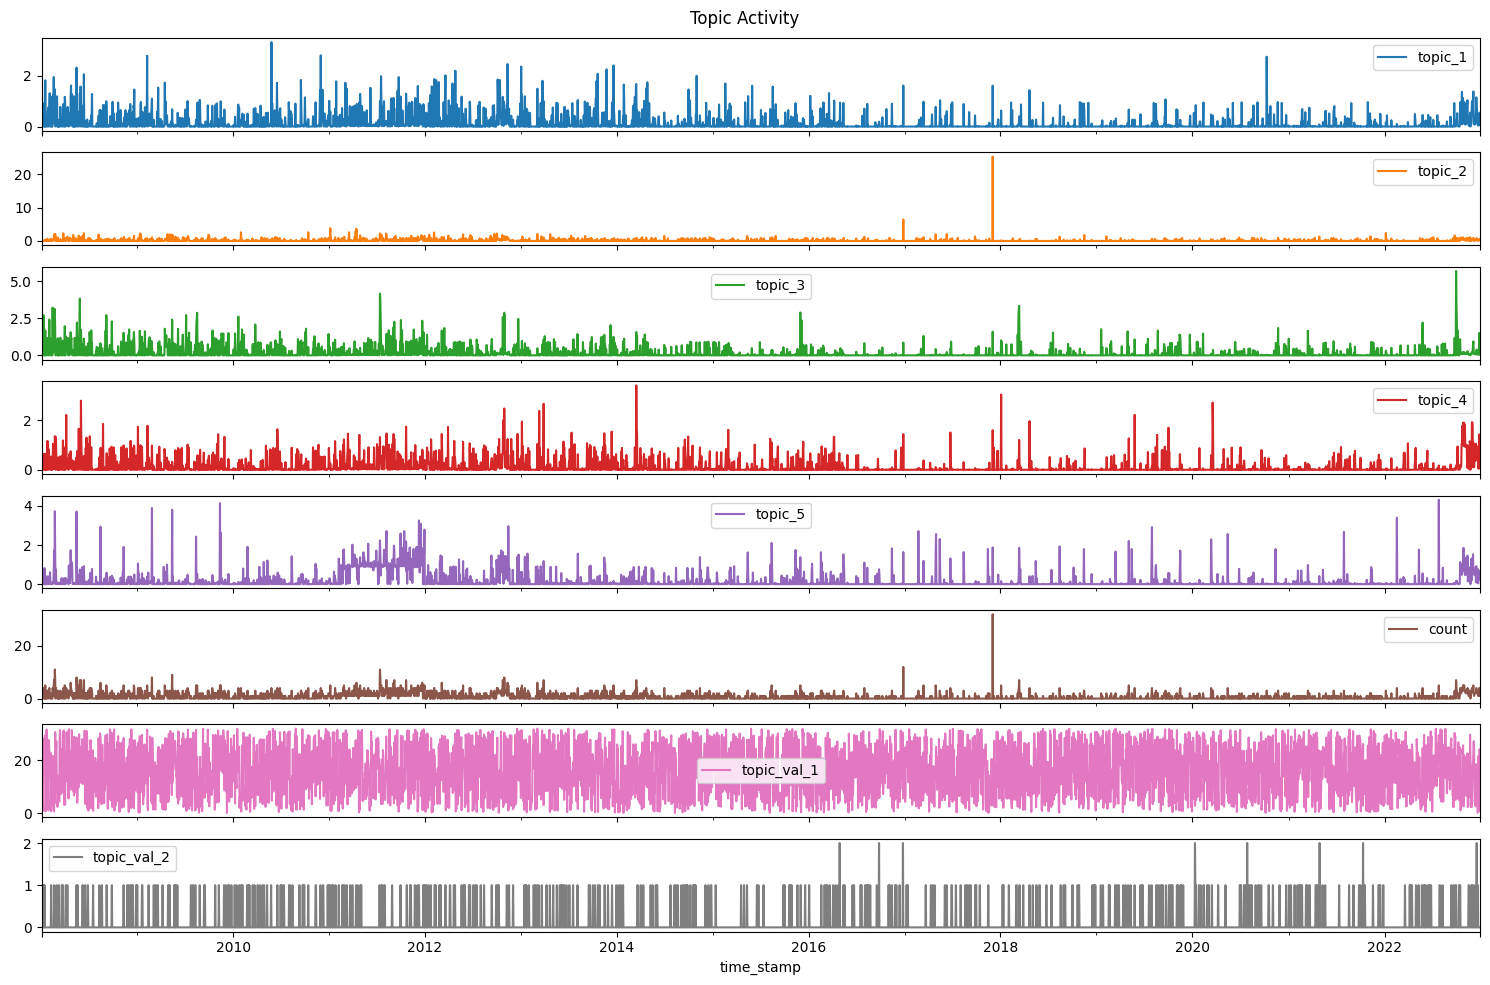

In [12]:
lda_topic_activity = create_topic_activity(lda_doc_topic, articles)

# safe to csv
lda_topic_activity.to_csv('data/rwe_lda_topic_activity.csv', sep=';')

## BERT Topic

In [13]:
from bertopic import BERTopic

2023-03-09 20:35:00.242346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarn

### Data preparation

In [14]:
bert_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    #ngram_range=(1, 2)
)

bert_dtm = bert_vectorizer.fit_transform(articles['title'])

### Evaluation

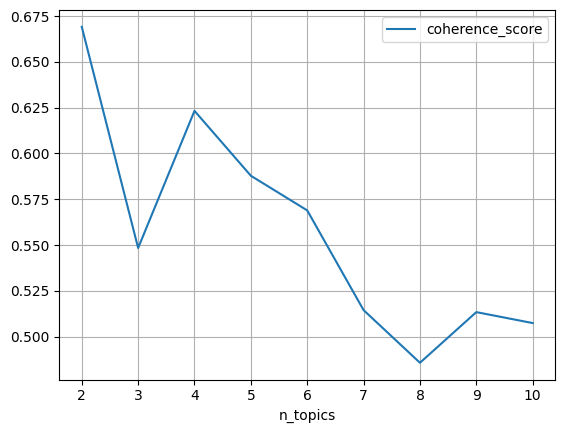

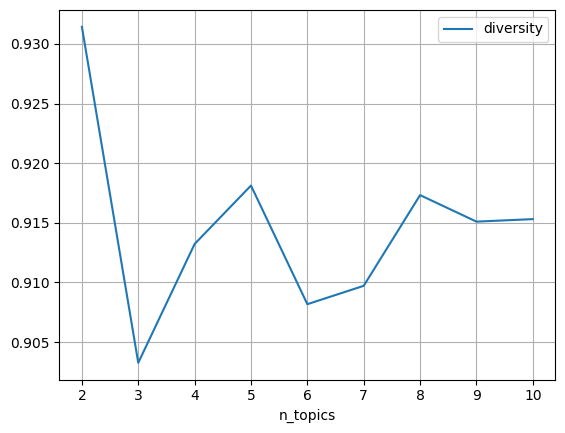

CPU times: user 11min 1s, sys: 25.6 s, total: 11min 26s
Wall time: 2min 33s


In [15]:
%%time
def compute_coherence_bertopic(topic_coherence, t):
    # reduce topics
    bertopic.reduce_topics(articles['title'], t)
    topics, probs = bertopic.transform(articles['title'])
    
    # Extract features for Topic Coherence evaluation
    topic_words = [[words for words, _ in bertopic.get_topic(topic)] for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=bert_tokens, 
        dictionary=dictionary, 
        topn=10,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    
    diversity = pairwise_word_embedding_distance(
        topic_words, 
        wv, 
        topk=10
    )
    
    # append to shared list
    topic_coherence.append([t, coherence, diversity])


os.environ["TOKENIZERS_PARALLELISM"] = 'false'
# train bertopic
bertopic = BERTopic(
    vectorizer_model=bert_vectorizer,
    language='english',
    calculate_probabilities=True,
    verbose=False
)
bertopic.fit(articles['title'])

# build bert tokens and dictonary
bert_tokens = articles['title'].apply(bertopic.vectorizer_model.build_analyzer()).to_list()
dictionary = corpora.Dictionary(bert_tokens)

# find optimal number of topics
topic_coherence = list()
max_topics = 10
for t in range(max_topics, 1, -1):
    compute_coherence_bertopic(topic_coherence, t)
os.environ["TOKENIZERS_PARALLELISM"] = 'true'

# plot
topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence_score', 'diversity'])
topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['coherence_score'], grid=True)
plt.show()

topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['diversity'], grid=True)
plt.show()


### Training

In [16]:
%%time
bert_model = BERTopic(
    nr_topics=5,
    vectorizer_model=bert_vectorizer,
    language='english',
    calculate_probabilities=True,
    verbose=False
)

bert_model.fit(articles['title'])

topics, probs = bert_model.transform(articles['title'])

"""
topics = bert_model.reduce_outliers(
    articles['title'], topics,
    strategy='c-tf-idf',
    probabilities=probs,
    threshold=0
)
"""
"""
bert_doc_topic = pd.DataFrame(
    columns=[f'topic_{i}' for i in range(probs.shape[1])],
    data=probs,
).round(4)
bert_doc_topic['topic_-1'] = (1 - bert_doc_topic.sum(axis='columns')).clip(0, 1)
"""
bert_doc_topic = pd.DataFrame(
    columns=['topic'],
    data=topics,
    dtype='object'
)
bert_doc_topic = pd.get_dummies(bert_doc_topic)
bert_doc_topic.columns = bert_model.get_topic_info()['Name'].values

CPU times: user 2min 36s, sys: 6.99 s, total: 2min 43s
Wall time: 32.4 s


### Results

Topic  Count                                 Name
0     -1   1917             -1_german_dea_report_gas
1      0    349          0_wind_farm_offshore_innogy
2      1    340                1_rise_index_dax_fall
3      2    165       2_profit_net_dividend_earnings
4      3    159  3_financial_report_forecast_outlook
5      4    150      4_patent_method_charge_inventor

remaining outliers: 1917


/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  icoord = scp.array(P["icoord"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  dcoord = scp.array(P["dcoord"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  ordered_labels = scp.array(P["ivl"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  color_list 

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



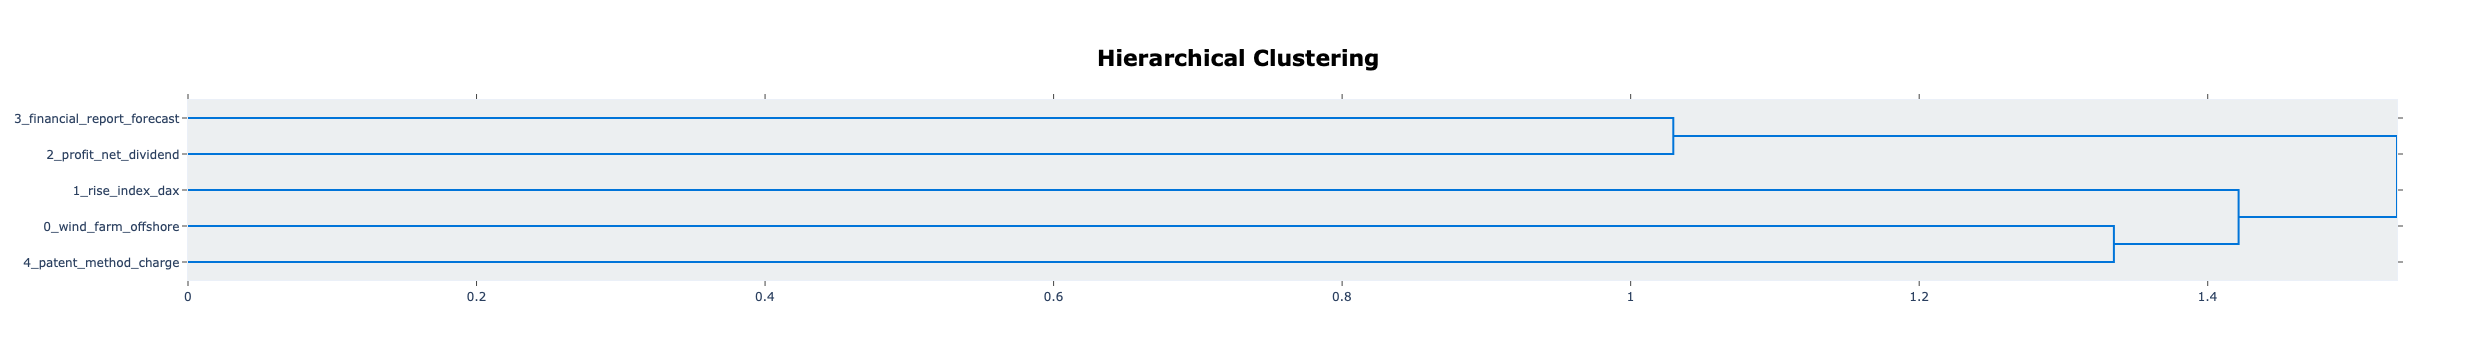

In [17]:
display(bert_model.get_topic_info())
print(f"remaining outliers: {bert_doc_topic.iloc[:, 0].sum()}")
bert_model.visualize_hierarchy()

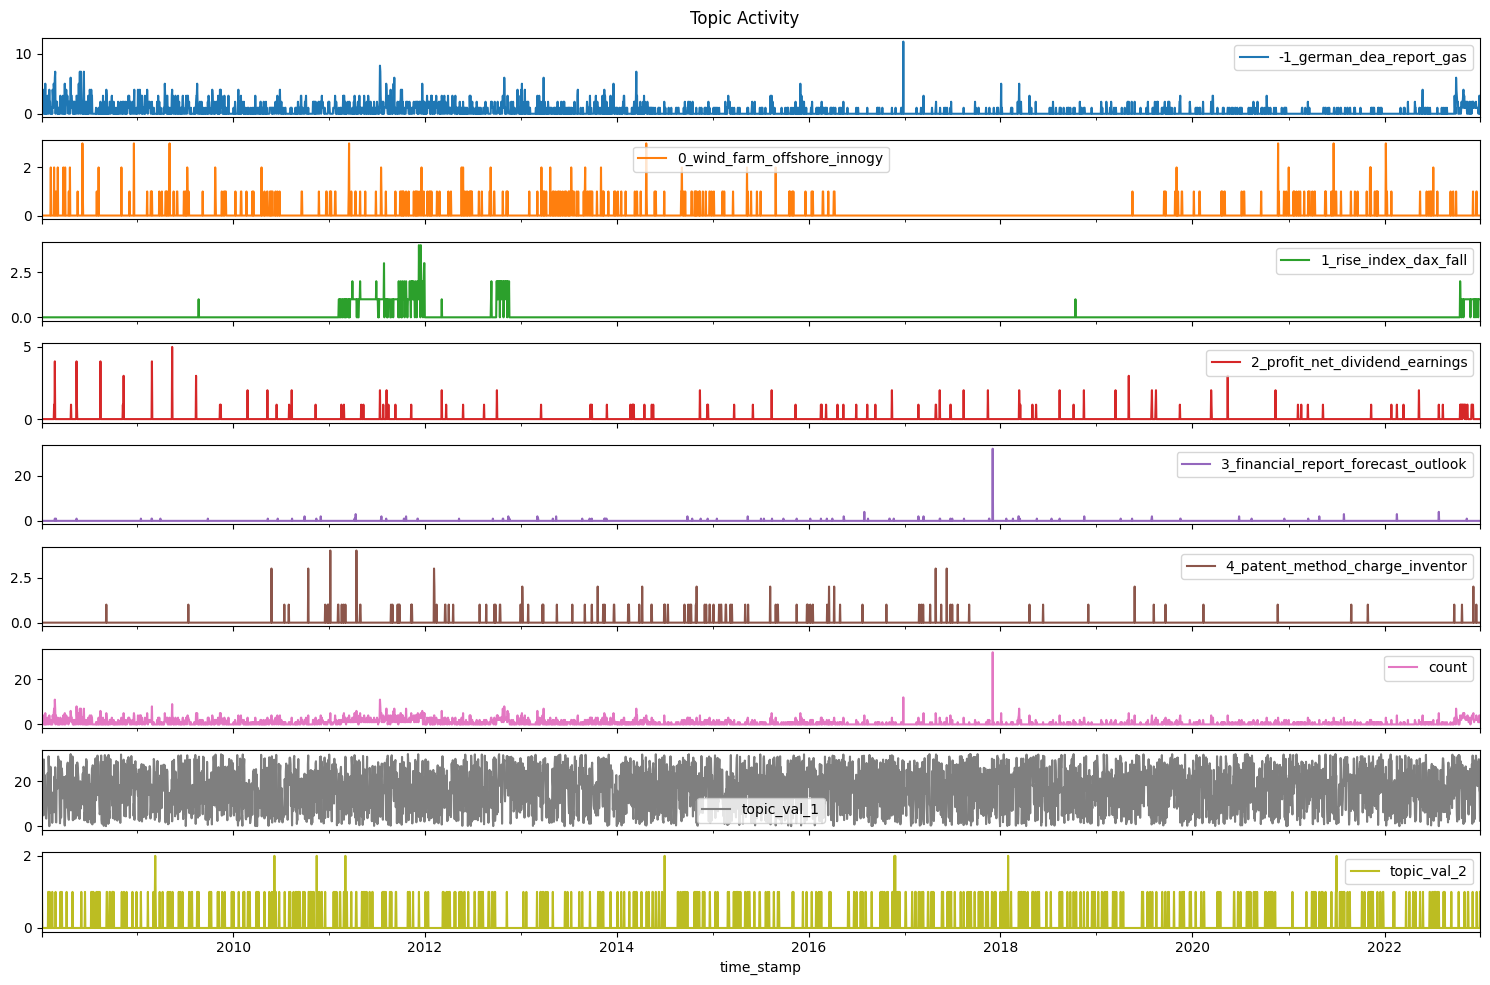

time_stamp  \
0    2014-08-22   
1    2009-09-03   
2    2011-04-11   
3    2008-09-11   
4    2009-01-15   
...         ...   
3075 2012-05-14   
3076 2022-10-27   
3077 2017-12-01   
3078 2013-06-18   
3079 2012-09-12   

                                                                     title  \
0     Germany to greenlight RWE deal to sell Dea unit to Russians - report   
1                      Price for RWE takeover of Essent trimmed by EUR950m   
2           RWE Gas Slovensko launches gas supplies to households - report   
3                       RWE says nuclear concession would boost renewables   
4              Fitch keeps RWE 's ratings despite Dutch Essent acquisition   
...                                                                    ...   
3075           RWE continues to review goals in regard to Nabucco Pipeline   
3076                   RWE ( RWE : EUR38.90) offers earnings yield of 5.2%   
3077                RWE AG ST Financial Reports: Financial statements 2012   
3078                       RWE submits plans for 1.2-GW offshore wind park   
3079              German RWE in talks to sell its 17% Nabucco stake to OMV   

      topic  
0        -1  
1        -1  
2        -1  
3        -1  
4        -1  
...     ...  
3075     -1  
3076      2  
3077      3  
3078      0  
3079     -1  

[3080 rows x 3 columns]

In [18]:
# Topic activity for Baseline
bert_topic_activity = create_topic_activity(bert_doc_topic, articles)
#bert_topic_activity = bert_topic_activity[bert_topic_activity.index < '2016-01-01']

# safe to csv
bert_topic_activity.to_csv('data/rwe_bert_topic_activity.csv', sep=';')

# Dataset for Advanced Approach
dataset = articles.copy()
dataset['topic'] = topics
dataset.to_csv('data/rwe_news_dataset.csv', sep=';', index=False)

display(dataset)

In [19]:
display(bert_model.get_topic_info())
display(dict(sorted(bert_model.get_representative_docs().items())))

Topic  Count                                 Name
0     -1   1917             -1_german_dea_report_gas
1      0    349          0_wind_farm_offshore_innogy
2      1    340                1_rise_index_dax_fall
3      2    165       2_profit_net_dividend_earnings
4      3    159  3_financial_report_forecast_outlook
5      4    150      4_patent_method_charge_inventor

{0: ['RWE puts online phase I of 67-MW German wind farm',
  'RWE to detonate WWII bombs at 576- MW wind farm off Wales - report',
  'RWE kicks off construction at 1.4- GW UK offshore wind farm',
  'RWE , Facebook , TVA partner to develop 150- MW solar farm in Tennessee',
  'RWE allows citizens to participate in 3 MW solar park',
  'RWE Renewables to build 2 solar farms in Spain'],
 1: ['RWE [Energy] rises 0.7% on low volume, rising for a second day, a 2-day rise of 2.5%',
  'RWE preference [Energy] falls 0.02% on weak volume for a second consecutive day, a two day fall of 1.0%',
  'RWE preference [Energy] rises 0.6%, rising for a third day, a 3-day rise of 4.9%',
  'RWE [ DAX index] rises 2.3%, for a 3-day rise of 6.6%, on high volatility and expanding price range',
  'RWE [ DAX index] rises 2.5% on high volatility',
  'RWE [ DAX index] drops 2.3% on high volatility',
  'RWE [ DAX index] falls in weak trading with rising open interest, weekly and monthly trend remains weak',
  'RWE [ D

In [20]:
view = articles[articles['time_stamp'].between('2016-01-01', '2019-01-01')].sort_values('time_stamp')
display(view)

time_stamp  \
1514 2016-01-07   
3048 2016-01-07   
934  2016-01-11   
1835 2016-01-13   
2587 2016-01-13   
...         ...   
681  2018-11-15   
49   2018-11-15   
1336 2018-11-16   
710  2018-11-30   
1330 2018-12-13   

                                                                                                                                                                                                                         title  
1514  Swiss Federal Institute of Intellectual Property granted patent to RWE Power Aktiengesellschaft on January 6, 2016 titled as "Sorbent for dry cleaning of waste gases loaded with mercury and method for its production"  
3048                                                                                                                                                       RWE AG - Power Plants and SWOT Analysis, 2015: Acute Market Reports  
934                                                                                                                                                                 RWE sells UK power station intended for biomass conversion  
1835                                                                                                                                                                         -Hildegard Muller to join RWE Group on 1 May 2016  
2587                                                                                                                                                             Germany 's RWE to jump into large solar segment, bid in Dubai  
...                                                                                                                                                                                                                        ...  
681                                                                   Clean Fine Coal Market Future Growth Witnessing High Demand by 2018-2025 by top key Players : Peabody, Arch Coal, Anglo American , RWE AG , BHP Billiton  
49                                                                                                                                                   - RWE 's business performs as planned in the first three quarters of 2018  
1336                                                                                                                                                             E.ON, RWE on track to complete blockbuster asset swap in 2019  
710                                                                                                         Australia: RWE Power Receives Patent for 'Method and system for gas scrubbing of aerosol-containing process gases'  
1330                                                                                                                                        -RWE Supervisory Board extends contract with Executive Board member Markus Krebber  

[277 rows x 2 columns]